In [38]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian1DKernel

def load_cube(filename):
    """Load the MUSE data cube."""
    return Cube(filename)

def calculate_pixel_scale(header):
    """Calculate the pixel scale in arcseconds per pixel."""
    wcs = WCS(header)
    cd_matrix = wcs.wcs.cd
    pixel_scale_arcsec = (abs(cd_matrix[0, 0]) * u.deg).to(u.arcsec).value
    return pixel_scale_arcsec

# without float centers

def aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec):
    """Extract flux within a circular aperture."""
    pixel_scale = calculate_pixel_scale(cube.primary_header)
    aperture_radius_pixels = aperture_radius_arcsec / pixel_scale

    aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
    
    # Get the shape of the cube
    ny, nx = cube.shape[1], cube.shape[2]
    y, x = np.ogrid[:ny, :nx]
    
    # Calculate the distance of each pixel from the center
    dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circular aperture
    mask = dist_from_center <= aperture_radius_pixels
    
    # Sum the flux within the masked area across spatial dimensions
    # Flux data is in 10**(-20) erg/s/cm²/Å
    flux_data = np.sum(cube.data[:, mask], axis=1)
    flux_density = (flux_data / aperture_area_arcsec2) 

    return Spectrum(wave=cube.wave, data=flux_density)


# Without Smoothing

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, match, aperture_radius_arcsec):
    """Plot the extracted spectrum with enhancements."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    plt.figure(figsize=(20, 8))
    spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel('Flux Density ($10^{-20}$erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    #plt.ylim(-100,100)
    #plt.xlim(lyman_alpha_obs_min-10, lyman_alpha_obs_max+10)
    plt.show()



In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import map_coordinates





# With smoothing

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, match, aperture_radius_arcsec, smoothing_sigma=3):
    """Plot the extracted spectrum with enhancements, including a smoothed line."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    # Extract wavelength and flux data
    wavelengths = spectrum.wave.coord()
    flux_density = spectrum.data

    # Convolve the flux with a Gaussian kernel to smooth the spectrum
    smoothed_flux = gaussian_filter1d(flux_density, sigma=smoothing_sigma)

    plt.figure(figsize=(20, 8))
    
    # Plot the original spectrum
    plt.plot(wavelengths, flux_density, color='green', linestyle='-', marker='', alpha=0.6, label='Original Spectrum')
    
    # Plot the smoothed spectrum
    plt.plot(wavelengths, smoothed_flux, color='black', linestyle='-', marker='', alpha=0.8, label=f'Smoothed Spectrum $\sigma$={smoothing_sigma}')
    
    # Add grey shaded area for Lyman-alpha range
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    # Customize the plot further
    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel(r'Flux Density ($10^{-20}$ erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    #plt.xlim(8000,8200)
    #plt.ylim(-50,50)
    
    plt.show()


cat2_label
----------
       
        30
        31
        30
        34
  cat2_xcentroid  
------------------
 
188.06635208664065
153.67859622010613
188.06635208664065
261.94468412406417
  cat2_ycentroid  
------------------
 289.6503845477449
296.49998556059916
 289.6503845477449
335.94044971865003

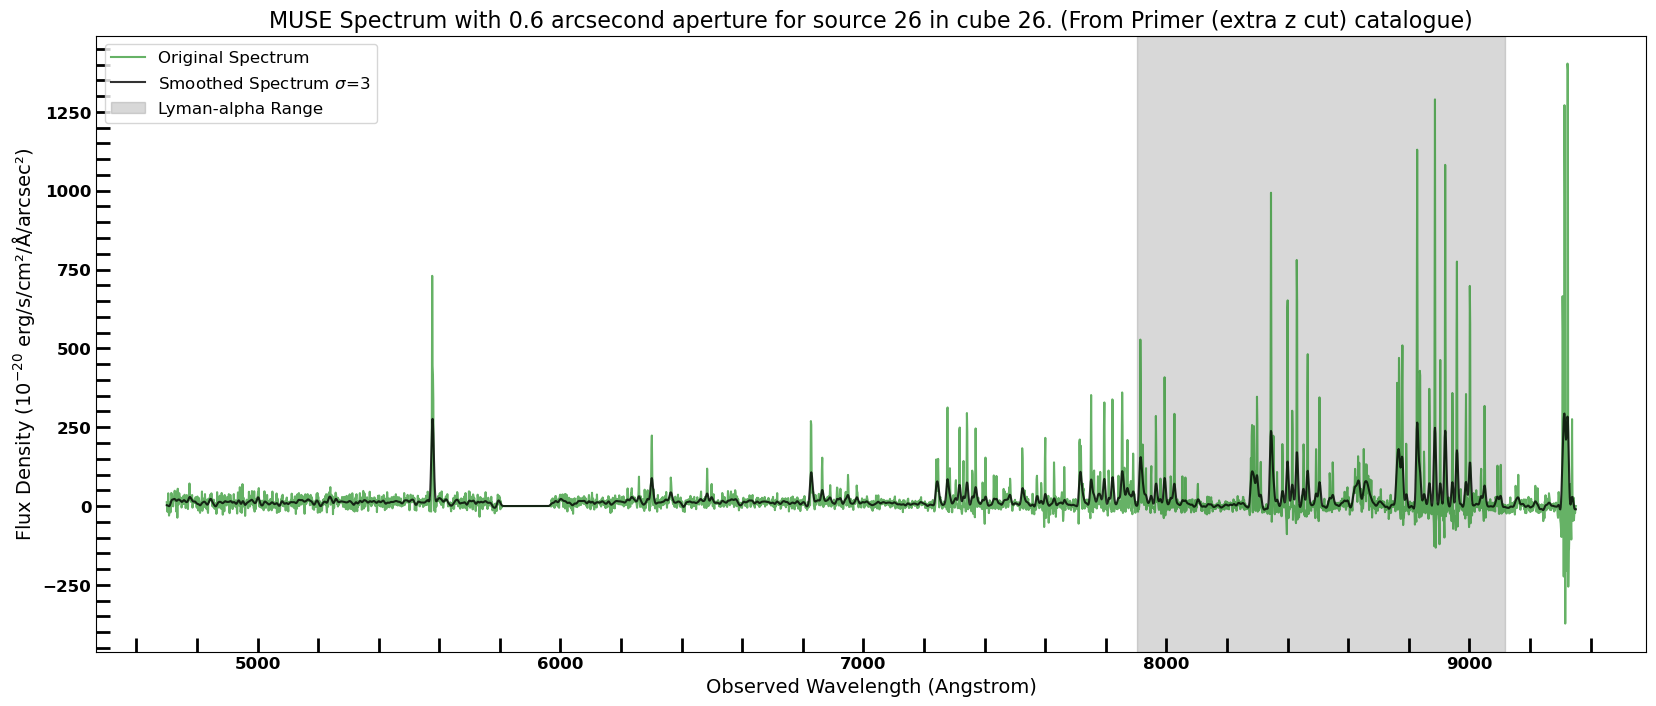

In [44]:
# Parameters
cube_no = '26'
match = 'Primer (extra z cut)'
x_center = 141
y_center = 219
cat2_label = '26'
aperture_radius_arcsec = 0.6
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'

# Load MUSE data cube
cube = load_cube(filename)

# Extract the spectrum within the aperture
spectrum = aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec)

# Define the redshift range and Lyman-alpha wavelength range
z_min, z_max = 5.5, 6.5
lyman_alpha_rest = 1215.67  # Angstroms
lyman_alpha_obs_min = lyman_alpha_rest * (1 + z_min)
lyman_alpha_obs_max = lyman_alpha_rest * (1 + z_max)

# Plot the spectrum
plot_spectrum(spectrum, (lyman_alpha_obs_min, lyman_alpha_obs_max), cat2_label, cube_no, match, aperture_radius_arcsec)


In [29]:
# With float centers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec):
    """Extract flux within a circular aperture, handling floating-point center coordinates."""
    pixel_scale = calculate_pixel_scale(cube.primary_header)
    aperture_radius_pixels = aperture_radius_arcsec / pixel_scale

    aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)

    # Create a grid for the pixel indices
    ny, nx = cube.shape[1], cube.shape[2]
    y, x = np.ogrid[:ny, :nx]
    
    # Calculate the distance of each pixel from the fractional center
    dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circular aperture
    mask = dist_from_center <= aperture_radius_pixels

    # Interpolate the data at the sub-pixel position
    coords = [np.arange(cube.shape[0]), np.full(cube.shape[0], y_center), np.full(cube.shape[0], x_center)]
    interpolated_flux = map_coordinates(cube.data, coords, order=1, mode='nearest')
    
    # Apply the mask and sum over the spatial dimensions
    flux_data = np.sum(interpolated_flux[:, mask], axis=1)
    
    # Convert flux to flux density
    flux_density = (flux_data / aperture_area_arcsec2) 
    
    return Spectrum(wave=cube.wave, data=flux_density)


# FOR ARRAY OF SOURCES


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube
from matplotlib.backends.backend_pdf import PdfPages

def load_cube(filename):
    """Load the MUSE data cube."""
    return Cube(filename)

def calculate_pixel_scale(header):
    """Calculate the pixel scale in arcseconds per pixel."""
    wcs = WCS(header)
    cd_matrix = wcs.wcs.cd
    pixel_scale_arcsec = (abs(cd_matrix[0, 0]) * u.deg).to(u.arcsec).value
    return pixel_scale_arcsec

def aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec):
    """Extract flux within a circular aperture."""
    pixel_scale = calculate_pixel_scale(cube.primary_header)
    aperture_radius_pixels = aperture_radius_arcsec / pixel_scale

    aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
    
    # Get the shape of the cube
    ny, nx = cube.shape[1], cube.shape[2]
    y, x = np.ogrid[:ny, :nx]
    
    # Calculate the distance of each pixel from the center
    dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circular aperture
    mask = dist_from_center <= aperture_radius_pixels
    
    # Sum the flux within the masked area across spatial dimensions
    flux_data = np.sum(cube.data[:, mask], axis=1)
    flux_density = (flux_data / aperture_area_arcsec2) 

    return Spectrum(wave=cube.wave, data=flux_density)

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, match, aperture_radius_arcsec, pdf):
    """Plot the extracted spectrum with enhancements and save it to a PDF."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    plt.figure(figsize=(20, 8))
    spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel('Flux Density ($10^{-20}$erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free memory

def extract_and_plot_spectra_for_sources(cube_filename, sources, aperture_radius_arcsec, pdf_filename, match):
    """Extract and plot spectra for multiple sources, saving the plots to a PDF."""
    cube = load_cube(cube_filename)
    
    # Define the redshift range and Lyman-alpha wavelength range
    z_min, z_max = 5.5, 6.5
    lyman_alpha_rest = 1215.67  # Angstroms
    lyman_alpha_obs_min = lyman_alpha_rest * (1 + z_min)
    lyman_alpha_obs_max = lyman_alpha_rest * (1 + z_max)
    
    with PdfPages(pdf_filename) as pdf:
        for i, (x_center, y_center, source_label) in enumerate(sources):
            # Extract the spectrum within the aperture
            spectrum = aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec)
            
            # Plot the spectrum and save to the PDF
            plot_spectrum(spectrum, (lyman_alpha_obs_min, lyman_alpha_obs_max), source_label, cube_filename[-7:-5], match, aperture_radius_arcsec, pdf)



In [41]:
# Parameters
cube_no = '26'
match = 'Primer (extra z cut)'
aperture_radius_arcsec = 0.6
filename = f'/Users/s2537809/MUSE/cube_{cube_no}.fits'
pdf_filename = f'/Users/s2537809/MUSE/Spectra/sources_cube_{cube_no}_cat_{match}_z3_4.pdf'

# List of sources as tuples: (x_center, y_center, source_label)
sources = [
    (309, 271, '45'),
    (124, 21, '1'),
    (152,103, '10'), 
    (101,123,'15') 
    
]

# Extract and plot spectra for the sources, saving them to a PDF
extract_and_plot_spectra_for_sources(filename, sources, aperture_radius_arcsec, pdf_filename, match)
